#Task 2.8

Plot vector field from denoysing AE. Plot heatmap for norm of it. Plot VAE density. Compare results. Analyze dependency of density estimation quality of AE from sigma. Dataset: multiple sintenic datasets from the paper.

Импортируем библиотеки

In [ ]:
from flax import linen as nn
from flax.training import train_state

import jax
from jax import random
import jax.numpy as jnp

import matplotlib.pyplot as plt

import numpy as np

import optax

import seaborn as sns

import torch.utils.data as data
from tqdm.notebook import tqdm

Сгенерируем выборку-спираль по формулам

$x = 0.04 t \sin t,\; y = 0.04 t \cos t,\; t \sim \text{Uniform}[3, 12]$

В статье написаны формулы $x = 0.04 \sin t,\; y = 0.04 \cos t$, но это не спираль и противоречит картинкам с датасетом из статьи, поэтому я добавила множитель $t$

In [ ]:
rng = random.PRNGKey(42)

def generate_data(size=10000, sigma=0.01):
    np.random.seed(42)
    t = np.random.uniform(3, 12, size=(size))
    noise = np.random.normal(0, sigma, size=(2, size))

    x = 0.04 * t * np.sin(t) + noise[0]
    y = 0.04 * t * np.cos(t) + noise[1]
    res = np.stack([x, y], 1)

    return res


def plot(res, ax=None):
    if ax is not None:
        ax.scatter(res[:, 0], res[:, 1], alpha=0.1);
    else:
        plt.scatter(res[:, 0], res[:, 1], alpha=0.1);


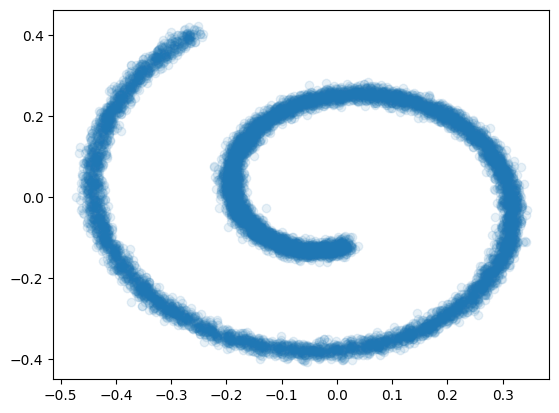

In [ ]:
dataset = generate_data()

plot(dataset)

Создадим классы denoising AE и VAE

In [ ]:
class AE(nn.Module):
    def setup(self):
        self.encoder = nn.Dense(features=16)
        self.decoder = nn.Dense(features=2)

    def __call__(self, x):
        x = self.encoder(x)
        x = nn.tanh(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def setup(self):
      self.encoder1 = nn.Dense(16)
      self.encoder2 = nn.Dense(2)

      self.decoder1 = nn.Dense(16)
      self.decoder2 = nn.Dense(4)

    def __call__(self, x):
      res = nn.tanh(self.encoder2(nn.tanh(self.encoder1(x))))
      mu_z, log_std_z = res[:, :1], res[:, 1:]

      eps = self.prior(log_std_z.shape)
      z = jnp.exp(log_std_z) * eps + mu_z
      out = self.decoder2(nn.tanh(self.decoder1(z)))

      mu_x, log_std_x = out[:, :2], out[:, 2:]
      return mu_z, log_std_z, mu_x, log_std_x

    def prior(self, n):
        return random.normal(rng, shape=n)

Необходимые функции для обучения моделей и отрисовка результатов

In [ ]:
def inint_model(model, dataset):
    _, inp_rng, init_rng = jax.random.split(rng, 3)

    params = model.init(init_rng, dataset)


    optimizer = optax.adamw(learning_rate=0.01)
    model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

    return model_state


def calculate_loss_AE(state, params, batch):
    preds = state.apply_fn(params, batch)
    return ((preds - batch) ** 2).mean()


def calculate_loss_VAE(state, params, batch):
    preds = state.apply_fn(params, batch)

    mu_z, log_std_z, mu_x, log_std_x = preds

    kl_div = log_std_z - log_std_x + (jnp.exp(log_std_x) ** 2 + (mu_x - mu_z) ** 2) / (2 * jnp.exp(log_std_z) ** 2) - 1/2
    nll = -(- 1/2 * ((batch - mu_x) / jnp.exp(log_std_x)) ** 2 - log_std_x - 1/2 * jnp.log(2 * jnp.pi))

    return kl_div.mean() + nll.mean()


# @jax.jit
def train_step(state, batch, model):
    if model == 0:
        grad_fn = jax.value_and_grad(calculate_loss_AE,
                                 argnums=1,  # Parameters are second argument of the function
                                )
    else:
        grad_fn = jax.value_and_grad(calculate_loss_VAE, argnums=1)

    # Calculate gradients
    loss, grads = grad_fn(state, state.params, batch)
    # Parameter update
    state = state.apply_gradients(grads=grads)

    return state, loss


def train_model(state, dataloader, num_epochs=2, freq=10, model=0):
    losses = []
    i = 0
    for epoch in tqdm(range(num_epochs)):

        for batch in dataloader:
            state, loss = train_step(state, batch, model)
            i += 1

            if i % freq == 0:
                losses.append(loss)

    return state, losses


def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)


def plot_vector_field_and_heatmap(model_state, dataset):
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    line = np.linspace(-0.5, 0.5)
    x_, y_ = np.meshgrid(line, line)
    all_data = np.stack([x_, y_], 2).reshape(-1, 2)
    preds = model_state.apply_fn(model_state.params, all_data)

    diff = preds - all_data

    # vector field
    ax[0, 0].quiver(x_, y_, diff[:, 0], diff[:, 1])
    plot(dataset, ax[0, 0])

    # heatmap
    sns.heatmap(np.log(np.linalg.norm(diff, axis=-1)).reshape(50, 50), ax=ax[1, 0], vmin=-10, vmax=-2)

    def get_ids(data, thr):
        square = np.abs(data) < thr
        ids = square[:, 0] & square[:, 1]
        return ids

    def get_crop(x_, ids, thr):
        n = int(thr * 100)
        return x_[ids.reshape(50, 50)].reshape(n, n)

    # Zoomed version
    thr = 0.3
    ids = get_ids(all_data, thr)
    diff = (preds - all_data)[ids]

    ax[0, 1].quiver(get_crop(x_, ids, thr), get_crop(y_, ids, thr), diff[:, 0], diff[:, 1])
    ax[0, 1].set_xlim(-thr, thr)
    ax[0, 1].set_ylim(-thr, thr)
    plot(dataset, ax[0, 1])

    sns.heatmap(np.log(np.linalg.norm(diff, axis=-1)).reshape(30, 30), ax=ax[1, 1], vmin=-10, vmax=-2);

def plot_vae_density(model_state, dataset):
    plt.figure(figsize=(10, 8))
    line = np.linspace(-0.5, 0.5)
    x_, y_ = np.meshgrid(line, line)
    all_data = np.stack([x_, y_], 2).reshape(-1, 2)
    *_, mu_x, log_std_x = model_state.apply_fn(model_state.params, all_data)

    # Data likelihood
    ll = (- 1/2 * ((all_data - mu_x) / jnp.exp(log_std_x)) ** 2 - log_std_x - 1/2 * jnp.log(2 * jnp.pi)).mean(1)
    sns.heatmap(ll.reshape(50, 50))

Функция для получения результатов для разных значений $\sigma$ - уровней зашумления датасета

In [ ]:
def train_model_and_plot_everything(mode=0, sigma=0.01):
    if mode == 0:
        model = AE()
    else:
        model = VAE()

    dataset = generate_data(sigma=sigma)
    model_state = inint_model(model, dataset)
    train_data_loader = data.DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)
    trained_model_state, losses = train_model(model_state, train_data_loader, model=mode)

    plt.figure(figsize=(4, 4))
    plt.plot(losses)
    plt.title("Loss")

    if mode == 0:
        plot_vector_field_and_heatmap(trained_model_state, dataset)
    else:
        plot_vae_density(trained_model_state, dataset)


## AE

Рассмотрим AE с различными уровнями шума, выведем векторное поле разниц между предсказаниями модели, обученной на спираль, и истинными значениями координат и heatmap норм этих векторов

  0%|          | 0/2 [00:00<?, ?it/s]

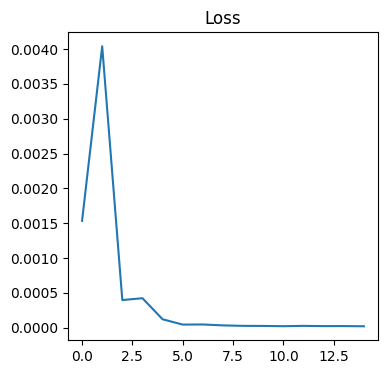

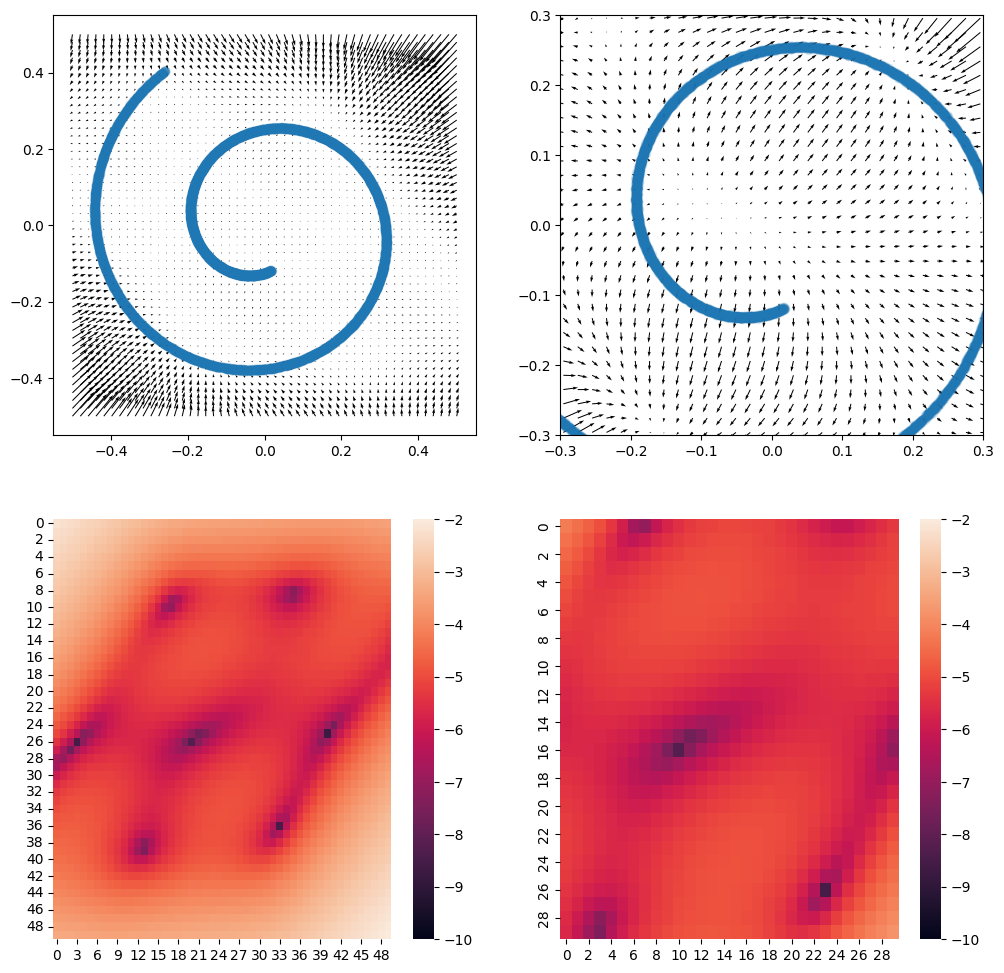

In [ ]:
train_model_and_plot_everything(0, sigma=0.001)

  0%|          | 0/2 [00:00<?, ?it/s]

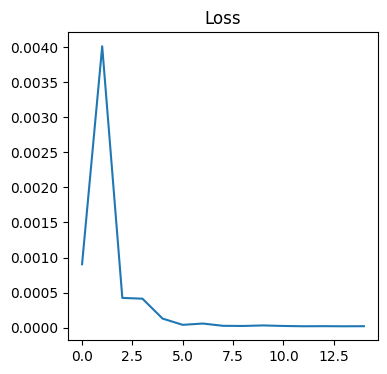

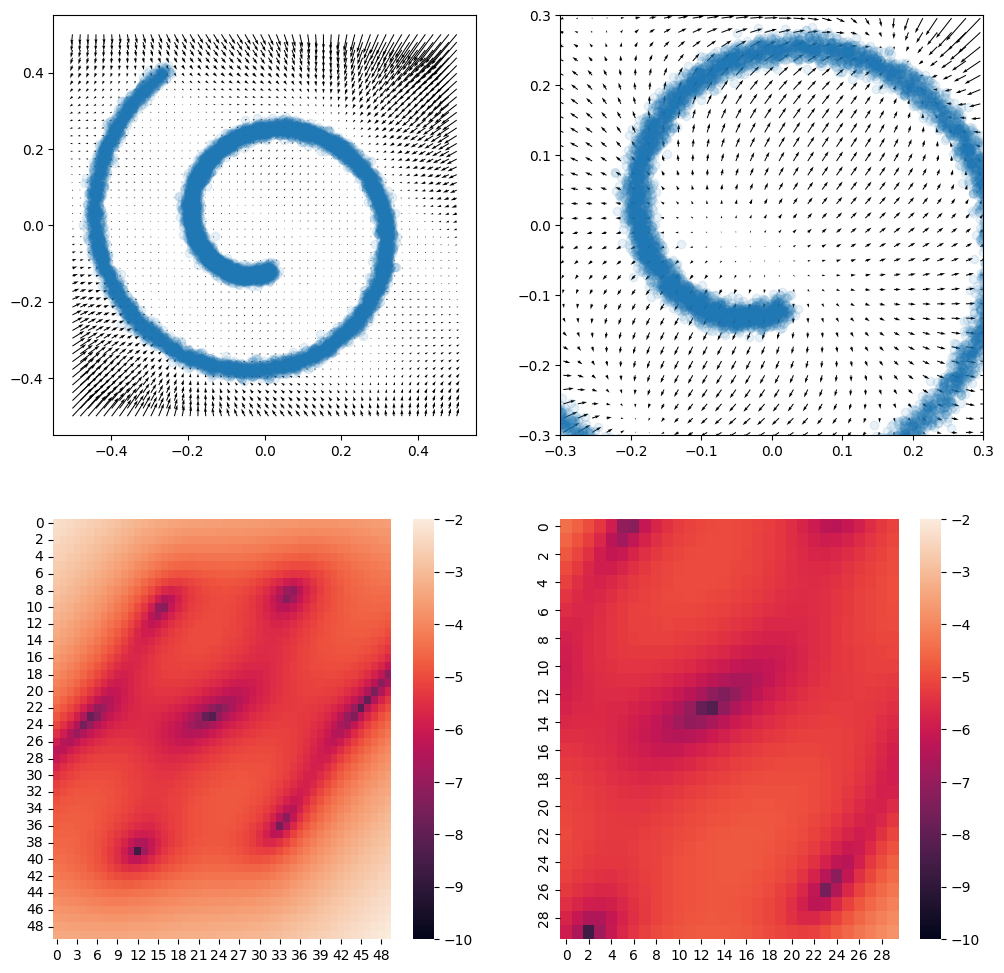

In [ ]:
train_model_and_plot_everything(0, sigma=0.01)

  0%|          | 0/2 [00:00<?, ?it/s]

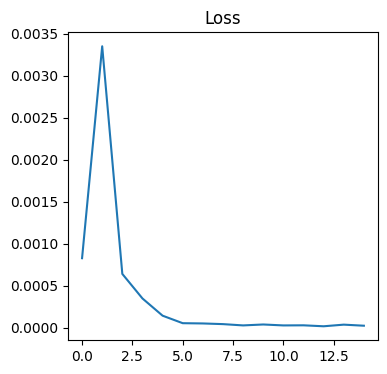

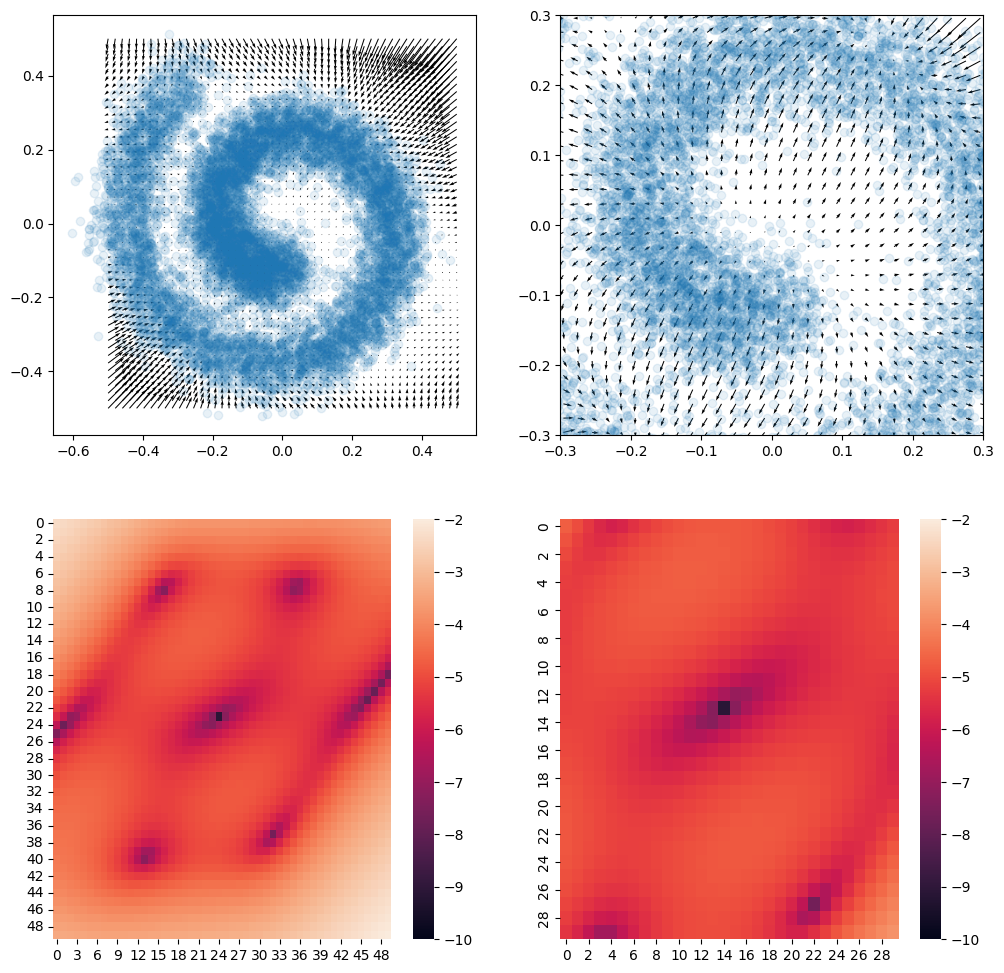

In [ ]:
train_model_and_plot_everything(0, sigma=0.05)

  0%|          | 0/2 [00:00<?, ?it/s]

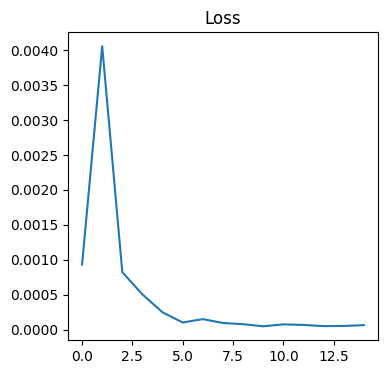

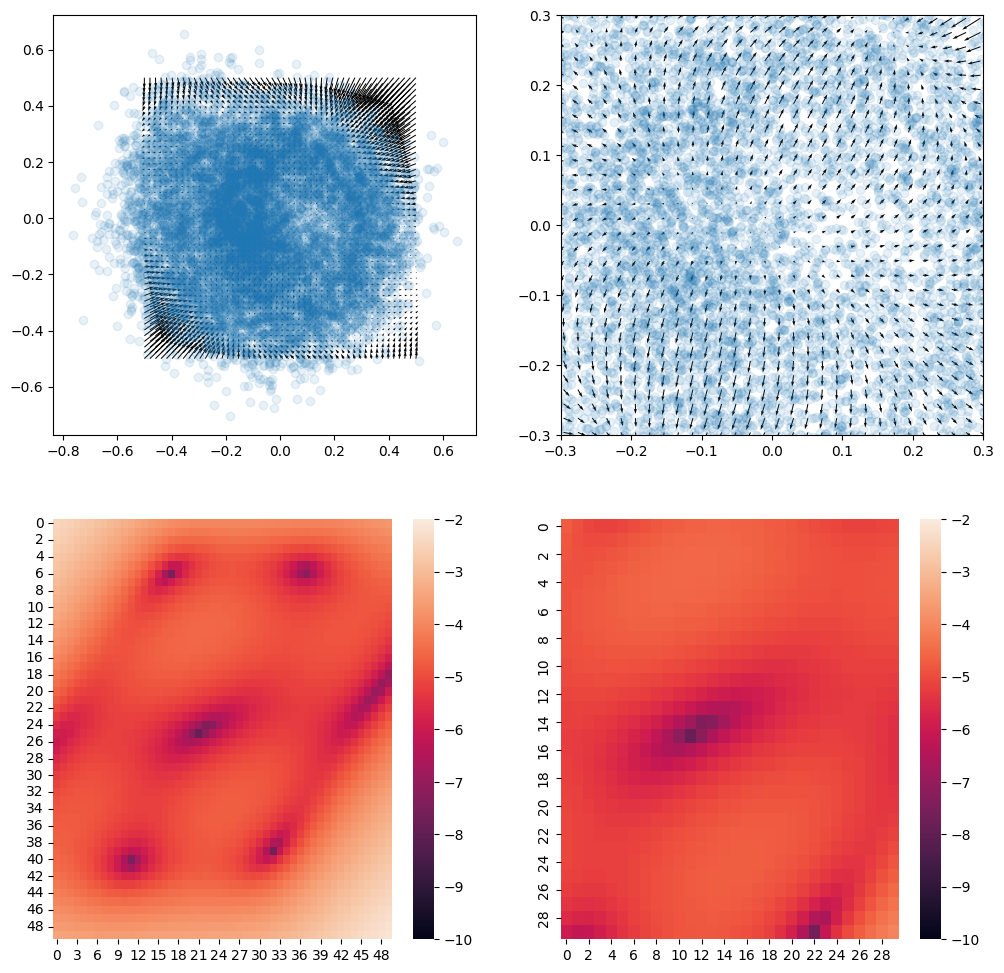

In [ ]:
train_model_and_plot_everything(0, sigma=0.1)

Видно, что векторное поле из наружних точек спирали направлено к спирали, а из центра координат к внешнему витку спирали, при большом значении $\sigma = 0.1$, видно, что регионов с маленькой нормой векторного поля стало меньше, по сравнению с меньшими значениями $\sigma$. Это может быть связано с тем, что модели сложно определиться с настоящей зависимостью и "остановиться" на спирали.

Heatmap не совсем совпадает с истинным распределением данных, но это может быть связано с простотой модели. Рассмотрим более сложную модель

In [ ]:
class AE(nn.Module):
    def setup(self):
        self.encoder = nn.Dense(features=16)
        self.middle1 = nn.Dense(features=32)
        self.middle2 = nn.Dense(features=32)
        self.decoder = nn.Dense(features=2)

    def __call__(self, x):
        x = self.encoder(x)
        x = nn.tanh(x)
        x = self.middle1(x)
        x = nn.tanh(x)
        x = self.middle2(x)
        x = nn.tanh(x)
        x = self.decoder(x)
        return x

  0%|          | 0/2 [00:00<?, ?it/s]

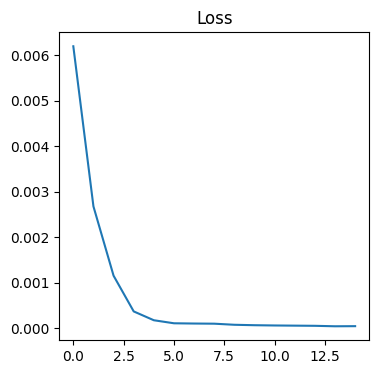

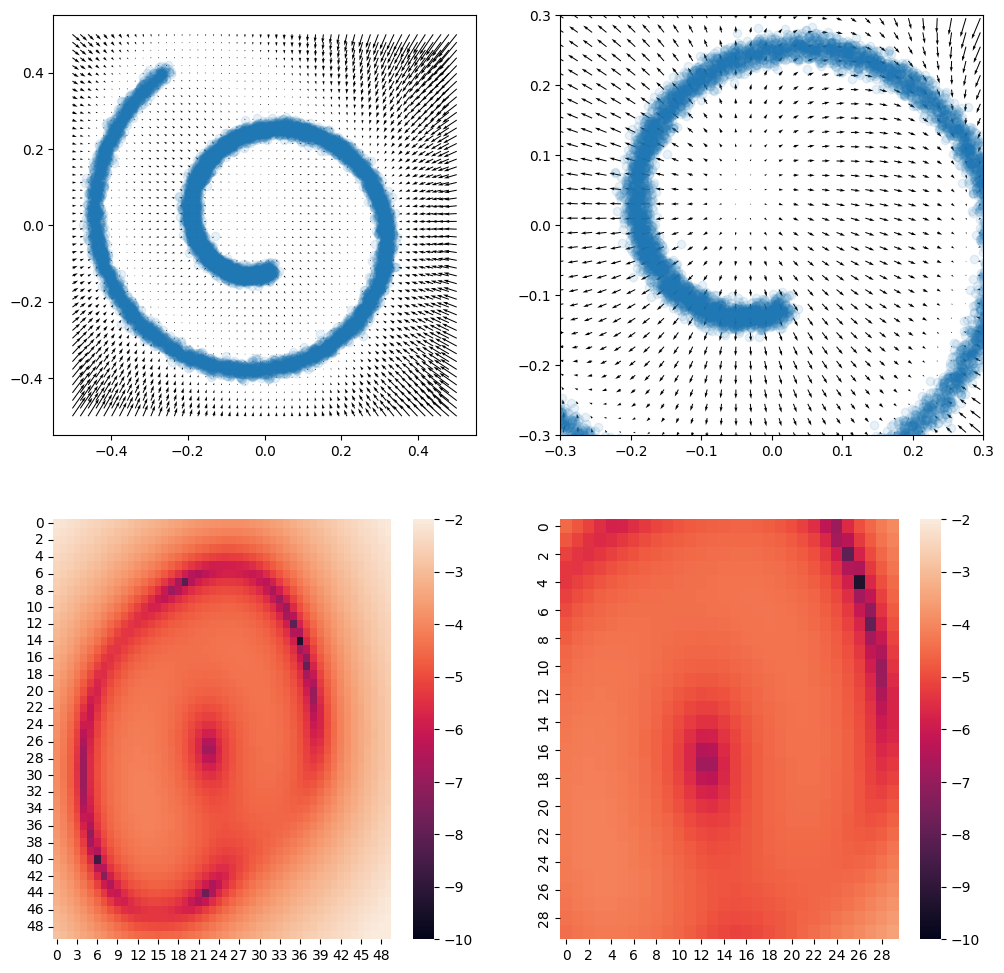

In [ ]:
train_model_and_plot_everything(0, sigma=0.01)

Получилось больше похоже на спираль, но все еще не совсем то

## VAE

Рассмотрим, heatmap VAE плотности

  0%|          | 0/2 [00:00<?, ?it/s]

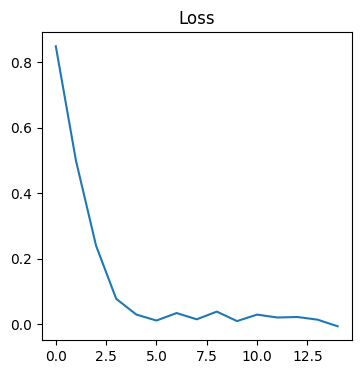

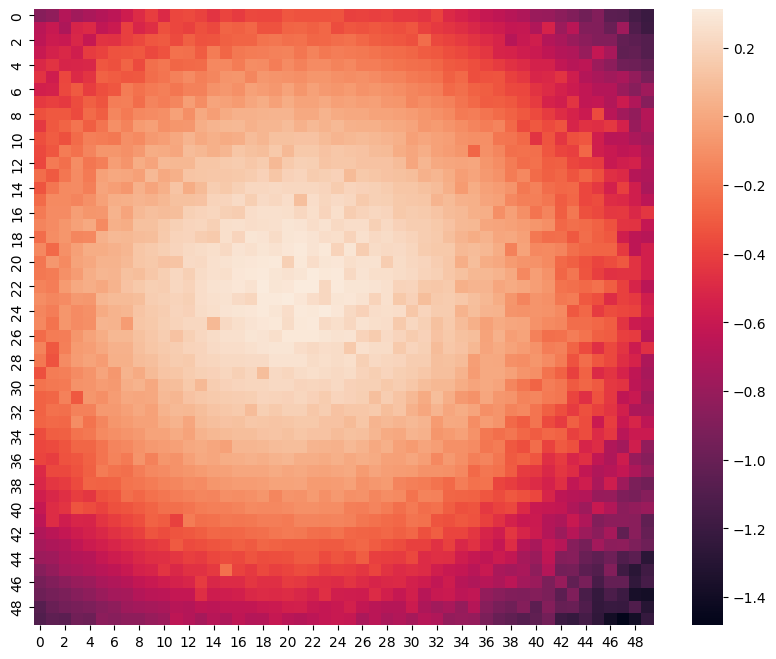

In [ ]:
train_model_and_plot_everything(1, sigma=0.001)

  0%|          | 0/2 [00:00<?, ?it/s]

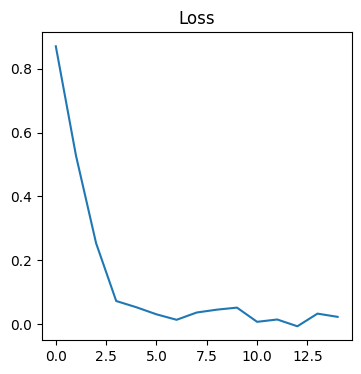

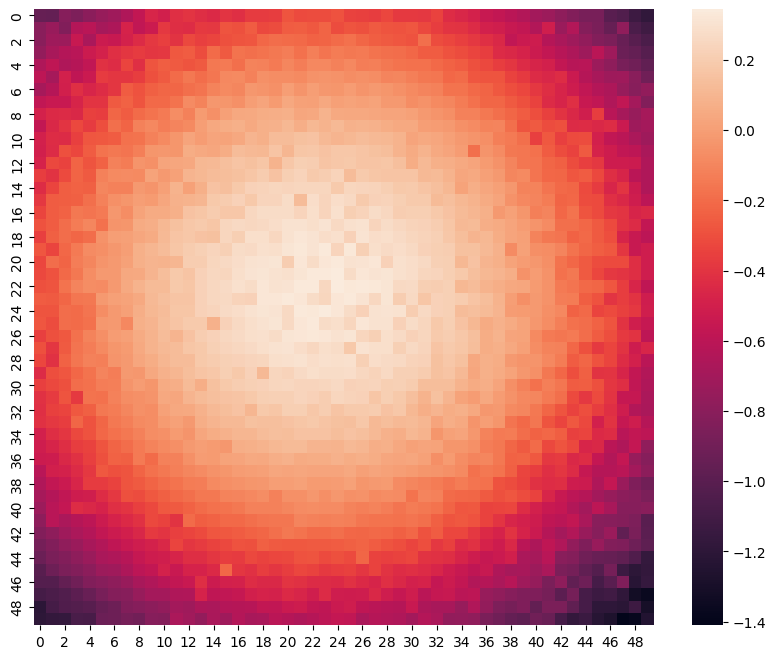

In [ ]:
train_model_and_plot_everything(1, sigma=0.01)

  0%|          | 0/2 [00:00<?, ?it/s]

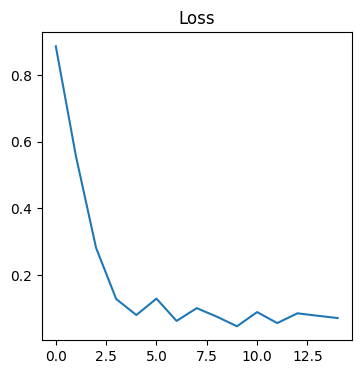

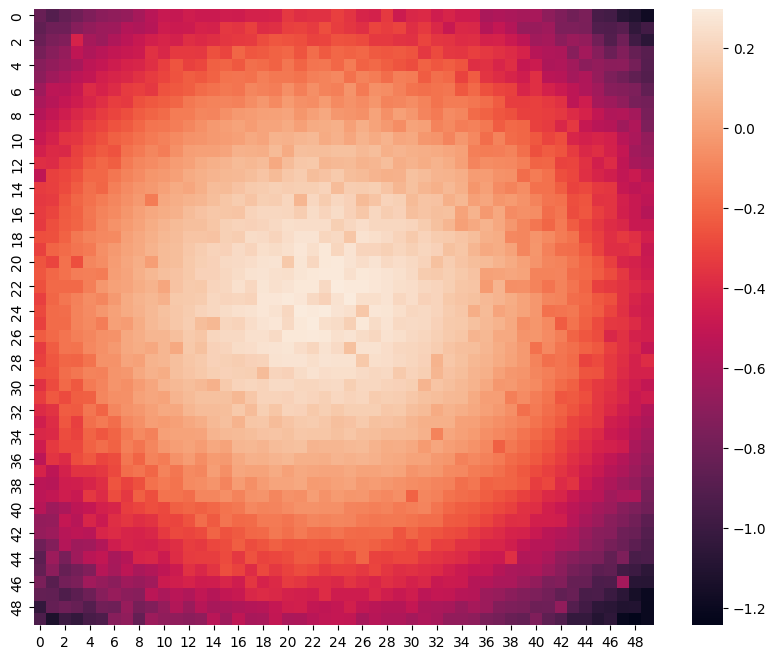

In [ ]:
train_model_and_plot_everything(1, sigma=0.1)

Плотность распределена нормально и покрывает область, в которой расположена спираль. Результаты не сильно изменяются от уровня шума, вероятно, из-за того, что мы приближаем выборку нормальным распределением, а шум не так сильно изменяет окружность, в которой содержится спираль

Если спираль будет вытянута, то и нормальное распределение изменится. Сделаем $x = 0.01 t \sin t$

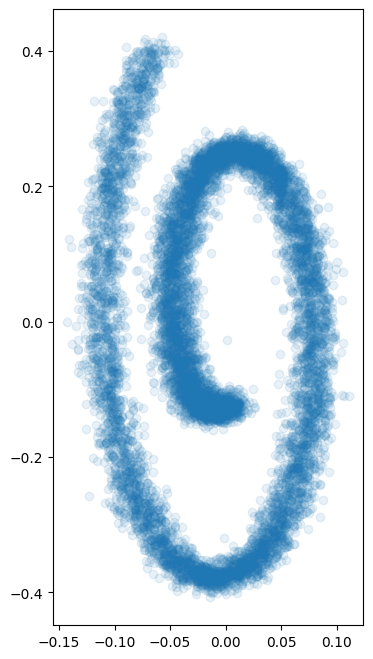

In [ ]:
def generate_data(size=10000, sigma=0.01):
    np.random.seed(42)
    t = np.random.uniform(3, 12, size=(size))
    noise = np.random.normal(0, sigma, size=(2, size))

    x = 0.01 * t * np.sin(t) + noise[0]
    y = 0.04 * t * np.cos(t) + noise[1]
    res = np.stack([x, y], 1)

    return res

dataset = generate_data()

plt.figure(figsize=(4, 8))
plot(dataset)

  0%|          | 0/2 [00:00<?, ?it/s]

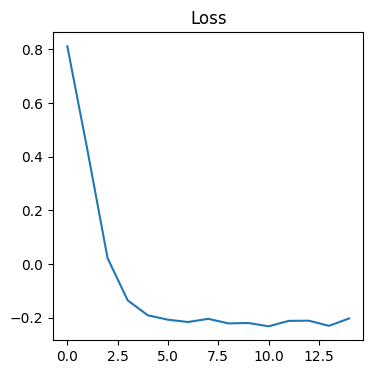

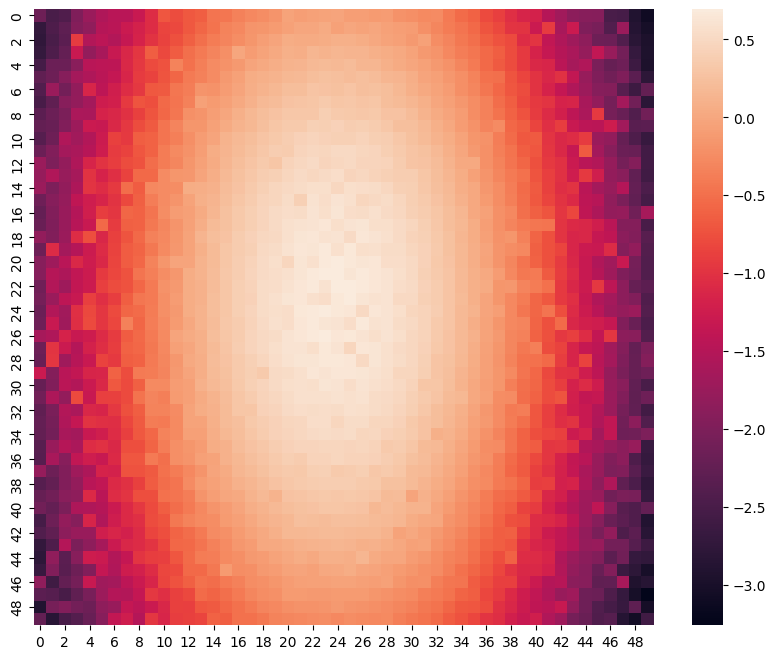

In [ ]:
train_model_and_plot_everything(1, sigma=0.01)

Получим, что нормальное распределение также вытянуто вдоль оси $Oy$